### Introduction

This notebook contains my code for the Boston housing dataset, using tree-based methods.

### Data Dictionary Housing Values in Suburbs of Boston

The Boston data frame has 506 rows and 14 columns.<br>
The <b>medv variable</b> is the target variable.<br>
<br>
<b>crim</b><br>
per capita crime rate by town.<br>
<br>
<b>zn</b><br>
proportion of residential land zoned for lots over 25,000 sq.ft.<br>
<br>
<b>inducrims</b><br>
proportion of non-retail business acres per town.<br>
<br>
<b>chas</b><br>
Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).<br>
<br>
<b>nox</b><br>
nitrogen oxides concentration (parts per 10 million).<br>
<br>
<b>rm</b><br>
average number of rooms per dwelling.<br>
<br>
<b>age</b><br>
proportion of owner-occupied units built prior to 1940.<br>
<br>
<b>dis</b><br>
weighted mean of distances to five Boston employment centres.<br>
<br>
<b>rad</b><br>
index of accessibility to radial highways.<br>
<br>
<b>tax</b><br>
full-value property minus tax rate per ten thousand dollars<br>
<br>
<b>ptratio</b><br>
pupil-teacher ratio by town.<br>
<br>
<b>black</b><br>
1 Thousand(Bk - 0.63)^2" where Bk is the proportion of blacks by town.<br>
<br>
<b>lstat</b><br>
lower status of the population (percent).<br>
<br>
<b>medv</b><br>
median value of owner-occupied homes in $1000s.<br>
<br>
<br>
<b>Sources:</b><br>
Harrison, D. and Rubinfeld, D.L. 1978 Hedonic prices and the demand for clean air. J. Environ. Economics and Management 5, 81–102.<br>
<br>
Belsley D.A., Kuh, E. and Welsch, R.E. 1980 Regression Diagnostics. Identifying Influential Data and Sources of Collinearity. New York: Wiley.<br>

## Import packages 

In [9]:
!python --version

Python 3.7.7


In [43]:
import numpy as np
import pandas as pd
import os
os.chdir("D:/Datasets")
import itertools
from math import sqrt
from scipy import stats as st
#import cvxopt

import sklearn 
from sklearn.preprocessing import StandardScaler, OneHotEncoder # used for variable scaling data
from sklearn.preprocessing import MinMaxScaler as Scaler # used for variable scaling data

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, RFE
from sklearn.compose import ColumnTransformer

import sklearn.linear_model 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, GradientBoostingClassifier, RandomForestClassifier

from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.metrics import make_scorer, accuracy_score 

from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_predict, cross_val_score

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram

import statsmodels.api as sm

from matplotlib import pyplot as plt
from matplotlib import rc
import seaborn as sns
sns.set_style("whitegrid")
sns.set(style="whitegrid", color_codes=True)
plt.rc("font", size=14)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pandas_profiling import ProfileReport

from pdpbox import pdp, get_dataset, info_plots
import shap

import eli5
from eli5.sklearn import PermutationImportance

import statistics

%matplotlib inline

<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [11]:
#def warn(*args, **kwargs):
#    pass
#import warnings
#warnings.warn = warn

### Load Data (Local Directory)

In [12]:
boston_df = pd.read_csv('boston_as2.csv')

print("Shape:", boston_df.shape,"\n")
print("Variable Types:") 
print(boston_df.dtypes)

# Removing the neighborhood column
boston_df = boston_df.drop('neighborhood', 1)
boston_df.head(10)

Shape: (506, 14) 

Variable Types:
neighborhood     object
crim            float64
zn              float64
indus           float64
chas              int64
nox             float64
rooms           float64
age             float64
dis             float64
rad               int64
tax               int64
ptratio         float64
lstat           float64
mv              float64
dtype: object


,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,19.15,22.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,17.10,18.9


## Exploratory Data Analysis (EDA) 

Review the dataset for missing values, and other patterns to be aware of.

<div class="alert alert-block alert-warning">
Attention to the <b>count</b> row for each column number of records
</div> 

In [14]:
#boston_df_copy = boston_df.copy(deep=True)
#profile = ProfileReport(boston_df_copy, title='Boston DF Preliminary Report', explorative=True)
#profile

In [15]:
#profile.to_file("Boston Housing Data EDA.html")

## Preprocess Data for Analysis

#### Normalizing Variable Distributions with Log Transformation 

Analysis of linear relationships between variables can introduce "0" (zero) values, these have to be removed to be able to work with Log transformation (normalization) of the data

<div class="alert alert-block alert-info">
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html
    </div>

y = (x**lmbda - 1) / lmbda,  for lmbda > 0<br>
    log(x),                  for lmbda = 0<br>

<b>boxcox</b> requires the input data to be positive. Sometimes a Box-Cox transformation provides a `shift parameter` to achieve this;<br> <b>boxcox</b> does not. Such a shift parameter is equivalent to adding a positive constant to x before calling boxcox.

#### Create Dataframe with Target Variable

In [16]:
boston_Target = boston_df["mv"].to_frame()
boston_Target.head(10)
boston_Target.shape

,mv
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2
5,28.7
6,22.9
7,22.1
8,16.5
9,18.9


(506, 1)

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br> 
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

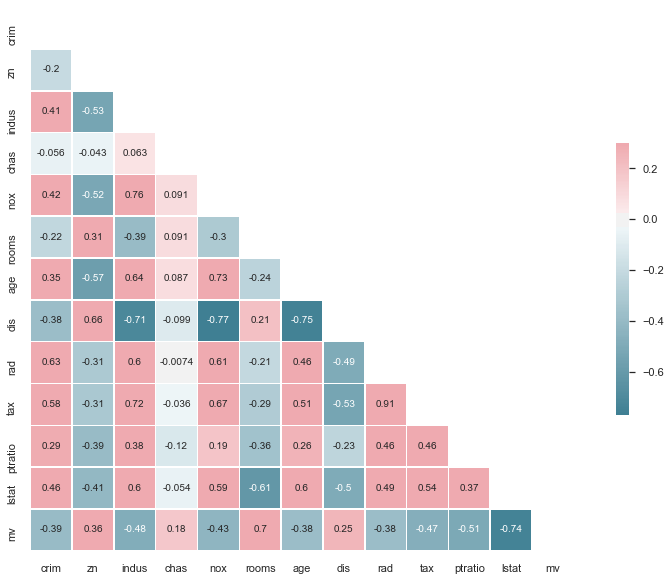

In [17]:
def corr_plot(some_df, method='pearson'):
    plt.figure(figsize=(15,10))
    corr = some_df.corr(method=method)
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    return

corr_plot(boston_df, method = 'pearson')

#### Plot the distribution of the target variable mv (median value of owner-occupied homes in $1000s)

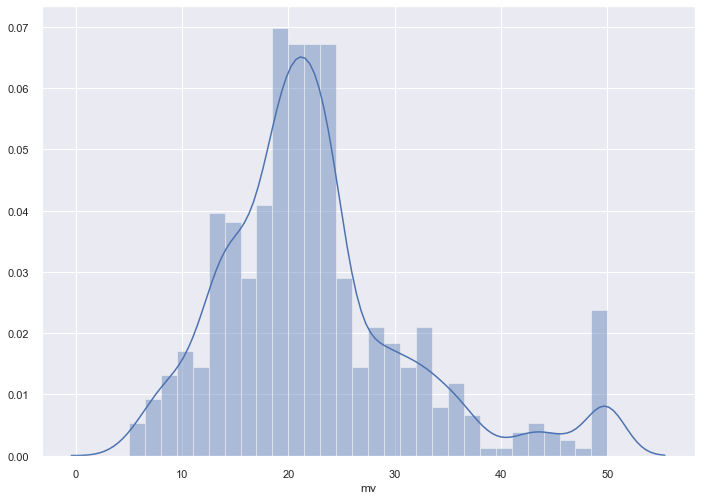

In [18]:
def get_histogram(field=boston_Target['mv']):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.distplot(field, bins=30)
    plt.show()
    return

get_histogram()

### Transformations

Before we scale the variables, we have look at the shape of the scatter plots to see if non-linear relationships with the target (mv) exist.

If so, then we have to apply a box-cox, log or sqrt transformation:

crim, zn, indus, nox, age, dis, rad, tax, ptratio - all vars except **rooms** and **lstat** appear to be non-linear

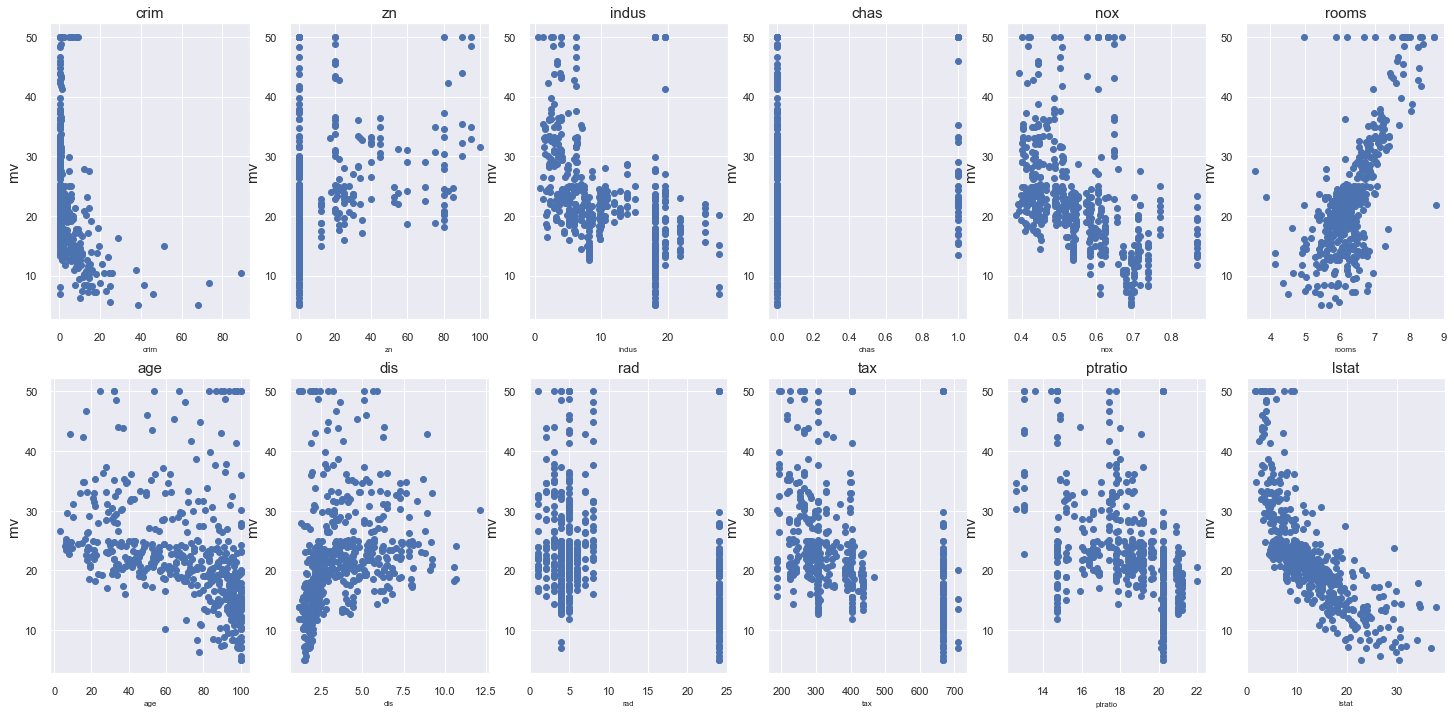

In [19]:
def plot_scatterplots(some_df):
    features = some_df.drop('mv', 1).columns
    target = some_df['mv']
    plt.figure(figsize=(25,25))
    for index, feature_name in enumerate(features):
        plt.subplot(4,len(features)/2, index+1)
        plt.scatter(some_df[feature_name], target)
        plt.title(feature_name, fontsize=15)
        plt.xlabel(feature_name, fontsize=8)
        plt.ylabel('mv', fontsize=15)
    return

plot_scatterplots(boston_df)

In [20]:
def box_cox_transform(df, col_list):
    transformed_df = df.copy(deep=True)
    for col in col_list:
        transformed_df[col] = df[col].apply(lambda x: x + 0.01)
        transformed_df[col] = transformed_df[col].transform(lambda x: st.boxcox(x)[0])
    return transformed_df

In [21]:
boston_df_bc = box_cox_transform(boston_df, col_list=['crim', 'zn', 'indus', 'nox', 'age', 'dis', 'rad', 'tax', 'ptratio'])
boston_df_bc.head(10)

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,-5.752617,1.708418,1.014663,0,-0.810467,6.575,201.842701,1.264160,0.009943,1.807153,33009.396839,4.98,24.0
1,-4.286098,-13.373080,3.075151,0,-1.064124,6.421,260.910666,1.416765,0.664175,1.796475,63758.135934,9.14,21.6
2,-4.286990,-13.373080,3.075151,0,-1.064124,7.185,184.938977,1.416765,0.664175,1.796475,63758.135934,4.03,34.7
3,-4.076712,-13.373080,0.932774,0,-1.111280,6.998,125.396307,1.568513,1.018925,1.791545,79016.524332,2.94,33.4
4,-3.107491,-13.373080,0.932774,0,-1.111280,7.147,157.365843,1.568513,1.018925,1.791545,79016.524332,5.33,36.2
5,-4.177151,-13.373080,0.932774,0,-1.111280,6.430,175.220890,1.568513,1.018925,1.791545,79016.524332,5.21,28.7
6,-2.790364,1.585824,3.330093,0,-0.856770,6.012,207.699584,1.503300,1.438062,1.809606,32081.227602,12.43,22.9
7,-2.164669,1.585824,3.330093,0,-0.856770,6.172,340.156589,1.554548,1.438062,1.809606,32081.227602,19.15,22.1
8,-1.698921,1.585824,3.330093,0,-0.856770,5.631,358.844298,1.570970,1.438062,1.809606,32081.227602,29.93,16.5
9,-1.963304,1.585824,3.330093,0,-0.856770,6.004,292.516257,1.630937,1.438062,1.809606,32081.227602,17.10,18.9


### Feature Selection & Cross-Validation

Set up the grid search for cross-validation and feature selection at the same time.

In [22]:
X = boston_df_bc.drop(['mv'], axis=1)
y = boston_Target['mv']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state = 1, test_size = 0.2)

### Linear Regression 

In [23]:
# Baseline model - This is a baseline model that uses all variables excluding neighborhood, without any feature selection.

def Linear_Regression_Baseline(X, y):
    numeric_features = [x for x in list(boston_df.columns.values) if x not in ['mv', 'chas']]
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_features = ['chas']
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=1)),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression(normalize = False))])
    
    search_space = [{'regressor__fit_intercept': [True, False]}]
    
    clf = GridSearchCV(pipe, search_space, cv=10, verbose=1, scoring = ['neg_root_mean_squared_error', 'r2'],
                      refit='neg_root_mean_squared_error')
    clf = clf.fit(X, y)
    return clf

In [24]:
lin_model_baseline = Linear_Regression_Baseline(X_train, Y_train)
lin_model_baseline_results = pd.DataFrame(lin_model_baseline.cv_results_)
lin_model_baseline_results

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__fit_intercept,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,...,split3_test_r2,split4_test_r2,split5_test_r2,split6_test_r2,split7_test_r2,split8_test_r2,split9_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,0.009896,0.012037,0.002901,0.000532,True,{'regressor__fit_intercept': True},-3.876231,-5.09996,-5.584208,-4.659206,...,0.792977,0.644191,0.762371,0.571605,0.73794,0.694216,0.767196,0.686366,0.103968,1
1,0.006201,0.000869,0.002794,0.000593,False,{'regressor__fit_intercept': False},-3.876231,-5.09996,-5.584208,-4.659206,...,0.792977,0.644191,0.762371,0.571605,0.73794,0.694216,0.767196,0.686366,0.103968,1


In [25]:
lin_model_baseline.best_estimator_
lin_model_baseline.best_score_

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

-4.794740575381522

### VIF - Variance Inflation Factors

Here are the variance inflation factors, for the entire dataset.

In [26]:
X1 = add_constant(X)
pd.Series([variance_inflation_factor(X1.values, i) 
               for i in range(X1.shape[1])], 
              index=X1.columns)

const      37537.217121
crim           6.829547
zn             2.066549
indus          3.892948
chas           1.074931
nox            6.781519
rooms          1.858778
age            3.525080
dis            5.154249
rad            3.875705
tax            3.411858
ptratio        1.635451
lstat          2.827164
dtype: float64

In [27]:
# Remove any VIF > 5 to try and fix multicollinearity problems.
# Nox is required for analysis, so can't be removed

low_vif_cols = ['zn', 'indus', 'chas', 'nox', 'rooms', 'age', 'rad', 'tax', 'ptratio', 'lstat']

In [28]:
# Transform the categorical variable 'chas' using One-hot Encoding
# Transform the other variables using standard scaler
# Passes this through to a Linear Regression model

def Linear_Regression(X, y):
    numeric_features = [x for x in low_vif_cols if x not in ['mv', 'chas']]
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_features = ['chas']
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=1)),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('selector', SelectKBest(f_regression, k="all")),
                           ('regressor', LinearRegression(fit_intercept = True, normalize = False))])
    
    search_space = [{'selector__k': [2, 4, 6, 8, 10]}]
    
    clf = GridSearchCV(pipe, search_space, cv=10, verbose=1, scoring = ['neg_root_mean_squared_error', 'r2'],
                      refit='neg_root_mean_squared_error')
    clf = clf.fit(X, y)
    return clf

In [29]:
lin_model = Linear_Regression(X_train[low_vif_cols], Y_train)
lin_model_results = pd.DataFrame(lin_model.cv_results_)
lin_model_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selector__k,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,...,split3_test_r2,split4_test_r2,split5_test_r2,split6_test_r2,split7_test_r2,split8_test_r2,split9_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,0.006598,0.001119,0.002907,0.000539,2,{'selector__k': 2},-4.847385,-5.461226,-6.797764,-5.167945,...,0.745299,0.544047,0.651267,0.512690,0.676889,0.598034,0.660919,0.589592,0.124642,5
1,0.006203,0.001160,0.003008,0.000447,4,{'selector__k': 4},-4.196725,-5.029715,-6.619725,-4.741039,...,0.785641,0.626740,0.691472,0.501848,0.688222,0.609548,0.707745,0.630438,0.127257,2
2,0.006991,0.001092,0.002903,0.000291,6,{'selector__k': 6},-4.026273,-5.021845,-6.576411,-4.757273,...,0.784171,0.615726,0.706311,0.475656,0.690660,0.594128,0.717705,0.630348,0.132277,3
3,0.007005,0.000019,0.003299,0.000466,8,{'selector__k': 8},-4.038532,-4.947050,-6.630848,-4.777894,...,0.782296,0.603057,0.679981,0.493787,0.700119,0.600296,0.716161,0.629704,0.130184,4
4,0.006598,0.000658,0.003094,0.000533,10,{'selector__k': 10},-4.168672,-5.214865,-6.420969,-4.685093,...,0.790670,0.622711,0.681414,0.472898,0.705179,0.624341,0.719184,0.631479,0.128425,1


In [30]:
lin_model.best_estimator_
lin_model.best_score_

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

-5.183896119740966

### Lasso Regression

In [31]:
def Lasso_Regression(X, y, alpha_values=[0.001, 0.01, 0.1, 1], selection_values=['cyclic', 'random']):
    numeric_features = [x for x in list(boston_df.columns.values) if x not in ['mv', 'chas']]
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_features = ['chas']
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=1)),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', Lasso(fit_intercept = True, normalize = False))])
    
    search_space = [{'regressor__alpha': alpha_values,
                     'regressor__selection': selection_values}]
    
    clf = GridSearchCV(pipe, search_space, cv=10, verbose=1,  scoring = ['neg_root_mean_squared_error', 'r2'],
                      refit='neg_root_mean_squared_error')
    clf = clf.fit(X, y)
    return clf

In [32]:
alpha_values = [0.0001, 0.001, 0.002, 0.01, 0.02, 0.1, 0.25, 0.5, 0.75, 1, 2, 4, 6, 8, 10]
lasso_model = Lasso_Regression(X_train, Y_train, alpha_values)
lasso_model_results = pd.DataFrame(lasso_model.cv_results_)
lasso_model_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.5s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,param_regressor__selection,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,...,split3_test_r2,split4_test_r2,split5_test_r2,split6_test_r2,split7_test_r2,split8_test_r2,split9_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,0.006305,0.001276,0.002299,0.000453,0.0001,cyclic,"{'regressor__alpha': 0.0001, 'regressor__selec...",-3.876161,-5.099772,-5.584411,...,0.792984,0.644191,0.762375,0.571618,0.737932,0.694204,0.767202,0.686368,0.103967,9
1,0.006600,0.000664,0.002295,0.000456,0.0001,random,"{'regressor__alpha': 0.0001, 'regressor__selec...",-3.876162,-5.100054,-5.584409,...,0.792985,0.644199,0.762375,0.571576,0.737933,0.694204,0.767201,0.686359,0.103980,10
2,0.005301,0.000459,0.002594,0.000498,0.001,cyclic,"{'regressor__alpha': 0.001, 'regressor__select...",-3.875523,-5.098017,-5.586206,...,0.793053,0.644193,0.762411,0.571730,0.737870,0.694085,0.767253,0.686387,0.103957,7
3,0.005503,0.000660,0.002501,0.000495,0.001,random,"{'regressor__alpha': 0.001, 'regressor__select...",-3.875521,-5.098153,-5.586185,...,0.793050,0.644194,0.762411,0.571732,0.737869,0.694090,0.767252,0.686385,0.103960,8
4,0.005095,0.000302,0.002498,0.000499,0.002,cyclic,"{'regressor__alpha': 0.002, 'regressor__select...",-3.874862,-5.096193,-5.588224,...,0.793125,0.644199,0.762452,0.571858,0.737799,0.693955,0.767309,0.686405,0.103950,5
5,0.005302,0.000456,0.002601,0.000490,0.002,random,"{'regressor__alpha': 0.002, 'regressor__select...",-3.874808,-5.096177,-5.588282,...,0.793121,0.644188,0.762450,0.571859,0.737796,0.693956,0.767309,0.686403,0.103951,6
6,0.005490,0.000915,0.002509,0.000502,0.01,cyclic,"{'regressor__alpha': 0.01, 'regressor__selecti...",-3.869729,-5.081401,-5.604981,...,0.793585,0.644150,0.762681,0.572839,0.737182,0.692887,0.767691,0.686489,0.103888,4
7,0.005195,0.000395,0.002501,0.000499,0.01,random,"{'regressor__alpha': 0.01, 'regressor__selecti...",-3.869592,-5.081201,-5.604965,...,0.793611,0.644149,0.762682,0.572818,0.737187,0.692863,0.767696,0.686493,0.103889,3
8,0.005003,0.000015,0.002602,0.000490,0.02,cyclic,"{'regressor__alpha': 0.02, 'regressor__selecti...",-3.864259,-5.063140,-5.627019,...,0.794013,0.643969,0.763194,0.573792,0.736329,0.691400,0.768040,0.686494,0.103879,2
9,0.005400,0.000485,0.002401,0.000492,0.02,random,"{'regressor__alpha': 0.02, 'regressor__selecti...",-3.864264,-5.063282,-5.627275,...,0.794060,0.644002,0.763211,0.573840,0.736330,0.691372,0.768055,0.686500,0.103890,1


In [33]:
lasso_model.best_estimator_
lasso_model.best_score_

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

-4.794177054793997

### Ridge Regression

In [34]:
def Ridge_Regression(X, y, alpha_values=[0.001, 0.01, 0.1, 1], solver_values = ['auto', 'saga']):
    numeric_features = [x for x in list(boston_df.columns.values) if x not in ['mv', 'chas']]
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_features = ['chas']
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=1)),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', Ridge(fit_intercept = True, normalize = False))])
    
    search_space = [{'regressor__alpha': alpha_values,
                     'regressor__solver':solver_values}]
    
    clf = GridSearchCV(pipe, search_space, cv=10, verbose=1, scoring = ['neg_root_mean_squared_error', 'r2'],
                      refit='neg_root_mean_squared_error')
    clf = clf.fit(X, y)
    return clf

In [35]:
alpha_values = [0.0001, 0.001, 0.002, 0.01, 0.02, 0.1, 0.25, 0.5, 0.75, 1, 2, 4, 6, 8, 10]
ridge_model = Ridge_Regression(X_train, Y_train, alpha_values)
ridge_model_results = pd.DataFrame(ridge_model.cv_results_)
ridge_model_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.0s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,param_regressor__solver,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,...,split3_test_r2,split4_test_r2,split5_test_r2,split6_test_r2,split7_test_r2,split8_test_r2,split9_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,0.007300,0.002056,0.003302,0.000636,0.0001,auto,"{'regressor__alpha': 0.0001, 'regressor__solve...",-3.876230,-5.099959,-5.584210,...,0.792977,0.644191,0.762371,0.571604,0.737939,0.694216,0.767196,0.686366,0.103968,27
1,0.007597,0.001289,0.003204,0.000748,0.0001,saga,"{'regressor__alpha': 0.0001, 'regressor__solve...",-3.877027,-5.099941,-5.584926,...,0.792633,0.644267,0.762433,0.571561,0.737919,0.694151,0.767140,0.686309,0.103938,30
2,0.005503,0.000497,0.002604,0.000493,0.001,auto,"{'regressor__alpha': 0.001, 'regressor__solver...",-3.876221,-5.099953,-5.584221,...,0.792979,0.644193,0.762372,0.571604,0.737939,0.694215,0.767197,0.686367,0.103968,26
3,0.006810,0.000878,0.002882,0.000294,0.001,saga,"{'regressor__alpha': 0.001, 'regressor__solver...",-3.876613,-5.099427,-5.583561,...,0.793042,0.644111,0.762384,0.571713,0.737933,0.694261,0.767264,0.686404,0.103937,20
4,0.006604,0.000670,0.002996,0.000022,0.002,auto,"{'regressor__alpha': 0.002, 'regressor__solver...",-3.876210,-5.099946,-5.584234,...,0.792980,0.644195,0.762373,0.571604,0.737938,0.694214,0.767198,0.686367,0.103969,25
5,0.006904,0.000947,0.002798,0.000407,0.002,saga,"{'regressor__alpha': 0.002, 'regressor__solver...",-3.875437,-5.101307,-5.585330,...,0.793231,0.644376,0.762178,0.571614,0.737899,0.694311,0.767287,0.686370,0.104052,23
6,0.005812,0.000398,0.003100,0.000696,0.01,auto,"{'regressor__alpha': 0.01, 'regressor__solver'...",-3.876127,-5.099889,-5.584337,...,0.792989,0.644210,0.762379,0.571602,0.737934,0.694205,0.767204,0.686369,0.103971,24
7,0.006499,0.000506,0.002799,0.000595,0.01,saga,"{'regressor__alpha': 0.01, 'regressor__solver'...",-3.875226,-5.100404,-5.584724,...,0.792930,0.644160,0.762416,0.571441,0.737920,0.694200,0.767276,0.686343,0.104027,28
8,0.005695,0.000641,0.002800,0.000593,0.02,auto,"{'regressor__alpha': 0.02, 'regressor__solver'...",-3.876022,-5.099818,-5.584466,...,0.793001,0.644230,0.762387,0.571600,0.737928,0.694193,0.767212,0.686372,0.103975,22
9,0.006499,0.000665,0.002897,0.000544,0.02,saga,"{'regressor__alpha': 0.02, 'regressor__solver'...",-3.875694,-5.098387,-5.583609,...,0.792898,0.644283,0.762478,0.571791,0.737953,0.694209,0.767020,0.686424,0.103876,18


In [36]:
ridge_model.best_estimator_
ridge_model.best_score_

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

-4.787411661155304

### Elastic Net Regression

In [37]:
def elastic_net_regression(X, y, alpha_values=[0.001, 0.002, 0.01, 0.1, 1], selection = ['cyclic', 'random'],
                          warm_start = [True, False], l1_ratio = [0.01, 0.02, 0.1, 0.25, 0.5, 0.75, 0.9]):
    numeric_features = [x for x in list(boston_df.columns.values) if x not in ['mv', 'chas']]
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_features = ['chas']
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=1)),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', ElasticNet(fit_intercept = True, normalize = False, max_iter=10000))])
    
    search_space = [{'regressor__alpha': alpha_values,
                     'regressor__selection':selection,
                     'regressor__warm_start': warm_start,
                     'regressor__l1_ratio':l1_ratio}]
    
    clf = GridSearchCV(pipe, search_space, cv=10, verbose=1, scoring = ['neg_root_mean_squared_error', 'r2'],
                      refit='neg_root_mean_squared_error')
    clf = clf.fit(X, y)
    return clf

In [38]:
enet_model = elastic_net_regression(X_train, Y_train)
enet_model_results = pd.DataFrame(enet_model.cv_results_)
enet_model_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 140 candidates, totalling 1400 fits


[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:   12.5s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,param_regressor__l1_ratio,param_regressor__selection,param_regressor__warm_start,params,split0_test_neg_root_mean_squared_error,...,split3_test_r2,split4_test_r2,split5_test_r2,split6_test_r2,split7_test_r2,split8_test_r2,split9_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,0.006497,0.000504,0.002806,0.000402,0.001,0.01,cyclic,True,"{'regressor__alpha': 0.001, 'regressor__l1_rat...",-3.872533,...,0.793398,0.644898,0.762655,0.571510,0.737729,0.693803,0.767484,0.686470,0.104091,50
1,0.005796,0.000591,0.002501,0.000501,0.001,0.01,cyclic,False,"{'regressor__alpha': 0.001, 'regressor__l1_rat...",-3.872533,...,0.793398,0.644898,0.762655,0.571510,0.737729,0.693803,0.767484,0.686470,0.104091,50
2,0.006311,0.000456,0.002591,0.000493,0.001,0.01,random,True,"{'regressor__alpha': 0.001, 'regressor__l1_rat...",-3.872532,...,0.793398,0.644898,0.762655,0.571510,0.737729,0.693803,0.767483,0.686470,0.104091,52
3,0.006198,0.000402,0.002500,0.000499,0.001,0.01,random,False,"{'regressor__alpha': 0.001, 'regressor__l1_rat...",-3.872529,...,0.793398,0.644898,0.762655,0.571512,0.737729,0.693803,0.767483,0.686470,0.104091,49
4,0.005200,0.000399,0.002701,0.000459,0.001,0.02,cyclic,True,"{'regressor__alpha': 0.001, 'regressor__l1_rat...",-3.872570,...,0.793396,0.644891,0.762652,0.571511,0.737731,0.693807,0.767481,0.686469,0.104090,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.005097,0.000301,0.002604,0.000492,1,0.75,random,False,"{'regressor__alpha': 1, 'regressor__l1_ratio':...",-4.791167,...,0.710049,0.671262,0.705817,0.502049,0.601024,0.578308,0.697577,0.610546,0.110146,117
136,0.005301,0.000458,0.002603,0.000491,1,0.9,cyclic,True,"{'regressor__alpha': 1, 'regressor__l1_ratio':...",-4.812166,...,0.718038,0.664650,0.693549,0.518271,0.616553,0.592126,0.694520,0.615697,0.103909,115
137,0.005195,0.000403,0.002404,0.000493,1,0.9,cyclic,False,"{'regressor__alpha': 1, 'regressor__l1_ratio':...",-4.812166,...,0.718038,0.664650,0.693549,0.518271,0.616553,0.592126,0.694520,0.615697,0.103909,115
138,0.005201,0.000404,0.002496,0.000498,1,0.9,random,True,"{'regressor__alpha': 1, 'regressor__l1_ratio':...",-4.812018,...,0.718030,0.664650,0.693565,0.518301,0.616539,0.592127,0.694524,0.615704,0.103907,114


In [39]:
enet_model.best_estimator_
enet_model.best_estimator_.named_steps['regressor']
enet_model.best_score_

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.01,
           max_iter=10000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='random', tol=0.0001, warm_start=False)

-4.78858639405767

In [40]:
enet_model.best_estimator_.named_steps['regressor'].coef_

array([ 0.78773699,  0.44076555, -0.99236094, -2.55705772,  2.33760818,
       -0.20192436, -4.06683251,  0.60030319, -1.45881152, -1.42926877,
       -4.49542985, -1.16645564,  1.16646242])

## Tree-Based Models

For tree-based models, no numeric variables need to be transformed in any way. Therefore, the datasets are redefined here:

In [41]:
boston_df

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


In [42]:
X = boston_df.drop(['mv'], axis=1)
y = boston_Target['mv']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state = 1, test_size = 0.2)

In [77]:
num_cols = X.columns.to_list()
num_cols.remove('chas')
num_cols

['crim',
 'zn',
 'indus',
 'nox',
 'rooms',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'lstat']

In [45]:
cat_cols = ['chas']

### Gradient Boosting Regressor

In [54]:
def gbm_regressor(X, Y, cat_features=cat_cols):

    categorical_features = cat_features
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first'))])

    preprocessor = ColumnTransformer(
        transformers=[('cat', categorical_transformer, categorical_features)], remainder = 'passthrough')

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', GradientBoostingRegressor(random_state = 1, max_features='log2',
                                                                     warm_start = True))])
    
    search_space = [{'classifier__loss': Categorical(['ls', 'lad', 'huber', 'quantile']),
                     'classifier__learning_rate': Real(1e-3, 1, prior='log-uniform'),
                     'classifier__n_estimators': Integer(25, 500),
                     'classifier__subsample': Real(0.01, 0.99, prior='log-uniform'),
                     'classifier__max_depth':Integer(1, 10)
                    }]
    
    clf = BayesSearchCV(pipe, search_space, cv=10, verbose=1, scoring = 'neg_root_mean_squared_error',
                        refit=True, random_state=1)
    clf = clf.fit(X, Y)
    return clf

In [55]:
gbm_model = gbm_regressor(X_train, Y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


In [56]:
gbm_model_results = pd.DataFrame(gbm_model.cv_results_)
gbm_model_results

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,...,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__loss,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__subsample,params
0,-2.572377,-4.150703,-5.247704,-3.731006,-3.104416,-3.223116,-4.734848,-3.589124,-5.834756,-2.860728,...,0.135197,0.003228,0.002111,0.000305,0.128214,huber,4,94,0.096427,{'classifier__learning_rate': 0.12821386062062...
1,-3.585850,-3.902507,-6.453301,-4.378026,-3.129200,-3.588764,-4.988458,-5.808916,-6.298421,-3.055769,...,0.106388,0.002207,0.002206,0.000405,0.112376,lad,1,232,0.063848,{'classifier__learning_rate': 0.11237567661049...
2,-15.588151,-16.918967,-9.937255,-15.230334,-11.744993,-14.192852,-14.505848,-14.097092,-16.233173,-17.195972,...,0.403007,0.006961,0.002392,0.000485,0.309882,huber,8,158,0.078334,{'classifier__learning_rate': 0.30988248973241...
3,-3.272517,-3.908682,-4.837398,-4.312965,-2.401404,-3.444447,-5.754458,-5.691869,-6.301211,-2.708629,...,0.124600,0.001021,0.002098,0.000301,0.128920,lad,2,216,0.068042,{'classifier__learning_rate': 0.12891994915697...
4,-5.149582,-5.522203,-7.160641,-4.916534,-3.543535,-4.446604,-4.835791,-6.268161,-4.944948,-3.439476,...,0.133001,0.002098,0.002300,0.000458,0.429591,lad,1,296,0.086935,{'classifier__learning_rate': 0.42959121911479...
5,-284.091311,-350.875601,-458.815535,-338.492798,-296.976540,-580.012618,-408.168546,-304.688385,-557.976985,-434.808843,...,0.172699,0.003288,0.002301,0.000459,0.799277,lad,6,119,0.178740,{'classifier__learning_rate': 0.79927713507842...
6,-3.291958,-4.767813,-5.318717,-4.825086,-3.032295,-4.157365,-4.610280,-4.599323,-6.557564,-3.214336,...,0.252693,0.003708,0.002306,0.000468,0.088952,huber,6,205,0.027443,{'classifier__learning_rate': 0.08895160416425...
7,-3.134507,-3.300088,-4.759206,-3.424740,-2.926853,-2.924460,-3.535975,-4.150874,-4.722665,-2.367631,...,0.095407,0.001203,0.002899,0.000300,0.008880,ls,8,284,0.186025,{'classifier__learning_rate': 0.00888047833214...
8,-2.946972,-3.421073,-4.550630,-3.144168,-2.701506,-3.082512,-2.922666,-3.715249,-5.192773,-2.197297,...,0.098504,0.001119,0.002697,0.000456,0.021992,ls,9,348,0.069206,{'classifier__learning_rate': 0.02199236113854...
9,-5.422475,-3.953187,-5.710097,-5.791779,-4.863507,-4.475430,-4.686861,-6.491082,-6.036100,-4.209911,...,0.164697,0.005497,0.003006,0.000012,0.002236,ls,7,377,0.515514,{'classifier__learning_rate': 0.00223580172388...


In [57]:
gbm_model.best_estimator_
gbm_model.best_score_
gbm_model.best_params_

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('onehot',
                                                                   OneHotEncoder(categories='auto',
                                                                                 drop='first',
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='error',
                                                                                 sparse=True))],
                                       

-2.959917093133662

OrderedDict([('classifier__learning_rate', 0.05647303341405854),
             ('classifier__loss', 'huber'),
             ('classifier__max_depth', 6),
             ('classifier__n_estimators', 217),
             ('classifier__subsample', 0.4645326937898789)])

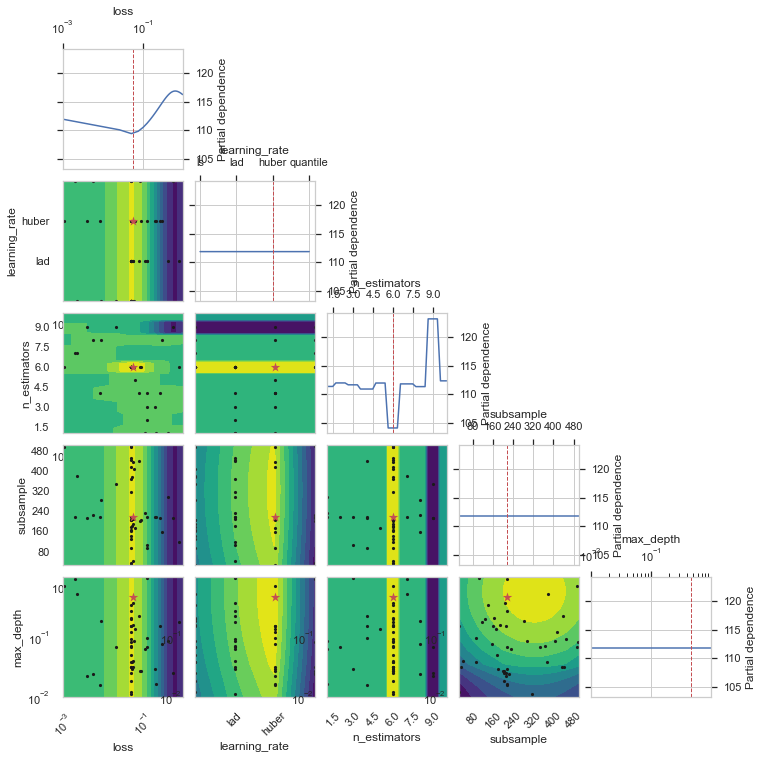

In [58]:
_ = plot_objective(gbm_model.optimizer_results_[0],
                   dimensions=["loss", "learning_rate", "n_estimators", "subsample", "max_depth"],
                   n_minimum_search=int(1e3))
plt.show()

### Random Forest Regressor

In [59]:
def rf_regressor(X, Y, cat_features=cat_cols):

    categorical_features = cat_features
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first'))])

    preprocessor = ColumnTransformer(
        transformers=[('cat', categorical_transformer, categorical_features)], remainder = 'passthrough')

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestRegressor(n_jobs = -1, random_state = 1,
                                                                oob_score = True, max_features = 'log2'))])
    
    search_space = [{'classifier__criterion': Categorical(['mse', 'mae']),
                     'classifier__n_estimators': Integer(25, 500),
                     'classifier__max_depth':Integer(1, 10)
                    }]
    
    clf = BayesSearchCV(pipe, search_space, cv=10, verbose=1, scoring = 'neg_root_mean_squared_error',
                        refit=True, random_state=1)
    clf = clf.fit(X, Y)
    return clf

In [60]:
rf_model = rf_regressor(X_train, Y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.6s finished


In [61]:
rf_model_results = pd.DataFrame(rf_model.cv_results_)
rf_model_results

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,...,std_test_score,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__n_estimators,params
0,-5.015149,-3.977293,-6.413850,-5.337926,-4.547067,-3.878208,-5.269834,-6.979306,-6.447366,-3.961949,...,1.068318,48,0.344395,0.341215,0.116313,0.004511,mse,2,204,"{'classifier__criterion': 'mse', 'classifier__..."
1,-3.750731,-3.100648,-5.263141,-3.691112,-3.396205,-3.240054,-3.598673,-4.340530,-4.875847,-2.828828,...,0.745891,46,0.062700,0.002327,0.115004,0.005023,mse,4,39,"{'classifier__criterion': 'mse', 'classifier__..."
2,-6.484308,-5.148165,-7.007358,-7.155981,-5.896254,-4.966918,-6.432536,-8.749690,-7.578893,-5.321128,...,1.130393,50,0.366508,0.005711,0.112696,0.004386,mse,1,391,"{'classifier__criterion': 'mse', 'classifier__..."
3,-3.413302,-2.743439,-4.813500,-3.801877,-3.178747,-3.110931,-3.303382,-3.798158,-5.000425,-2.685233,...,0.749840,45,0.112409,0.002826,0.112199,0.004287,mse,5,82,"{'classifier__criterion': 'mse', 'classifier__..."
4,-3.792881,-3.068497,-5.347931,-3.708467,-3.369258,-3.275885,-3.656902,-4.341641,-4.966170,-2.839287,...,0.774306,47,0.059624,0.001749,0.112900,0.002661,mse,4,37,"{'classifier__criterion': 'mse', 'classifier__..."
5,-3.344210,-2.768467,-4.804510,-3.710841,-3.133162,-3.066674,-3.369222,-3.821557,-4.946187,-2.564449,...,0.754091,44,0.348905,0.004734,0.127204,0.035154,mse,5,309,"{'classifier__criterion': 'mse', 'classifier__..."
6,-5.035331,-4.004177,-6.392918,-5.348532,-4.548065,-3.865056,-5.383126,-6.998048,-6.524255,-3.930527,...,1.081506,49,0.350803,0.005120,0.115508,0.003800,mse,2,311,"{'classifier__criterion': 'mse', 'classifier__..."
7,-2.991860,-2.651558,-4.358639,-3.812707,-2.879234,-2.723033,-3.004828,-3.654120,-4.339789,-2.212007,...,0.698033,36,0.439310,0.004809,0.116601,0.005138,mae,8,417,"{'classifier__criterion': 'mae', 'classifier__..."
8,-3.262877,-2.721801,-4.708192,-3.870127,-2.962334,-2.891100,-3.352842,-3.764616,-4.571202,-2.482554,...,0.719838,43,0.459406,0.007329,0.116706,0.003663,mae,6,436,"{'classifier__criterion': 'mae', 'classifier__..."
9,-3.020122,-2.672868,-4.607040,-3.738062,-2.814711,-2.791410,-3.239728,-3.635610,-4.443760,-2.257580,...,0.733272,38,0.387408,0.006722,0.116303,0.004273,mae,7,322,"{'classifier__criterion': 'mae', 'classifier__..."


In [62]:
rf_model.best_estimator_
rf_model.best_score_
rf_model.best_params_

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('onehot',
                                                                   OneHotEncoder(categories='auto',
                                                                                 drop='first',
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='error',
                                                                                 sparse=True))],
                                       

-3.1633997300781336

OrderedDict([('classifier__criterion', 'mse'),
             ('classifier__max_depth', 10),
             ('classifier__n_estimators', 500)])

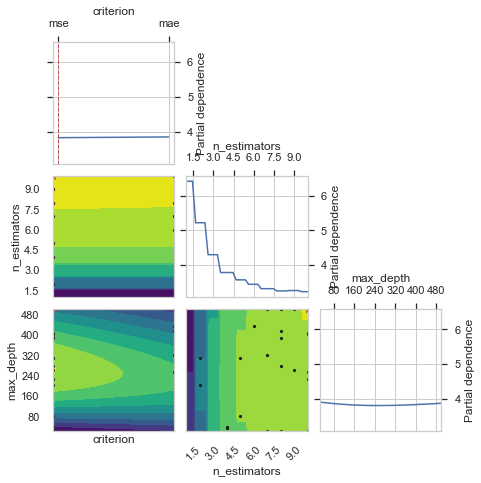

In [63]:
_ = plot_objective(rf_model.optimizer_results_[0],
                   dimensions=["criterion", "n_estimators", "max_depth"],
                   n_minimum_search=int(1e8))
plt.show()

### Comparing Models

Here are the best models by RMSE:.

In [65]:
model_scores = pd.DataFrame({'Linear Regression (Baseline)': abs(lin_model_baseline.best_score_),
                             'Linear Regression (Selection)': abs(lin_model.best_score_),
                             'Lasso': abs(lasso_model.best_score_),
                             'Ridge': abs(ridge_model.best_score_),
                             'Elastic-Net': abs(enet_model.best_score_),
                             'Gradient Boosting Regressor': abs(gbm_model.best_score_),
                             'Random Forest Regressor': abs(rf_model.best_score_)}, index = [1]).T.reset_index()

model_scores.rename(columns = {'index' : 'Model', 1:'RMSE_CV'}, inplace=True)
model_scores.sort_values(by=['RMSE_CV'], ascending=True)

,Model,RMSE_CV
5,Gradient Boosting Regressor,2.959917
6,Random Forest Regressor,3.163400
3,Ridge,4.787412
4,Elastic-Net,4.788586
2,Lasso,4.794177
0,Linear Regression (Baseline),4.794741
1,Linear Regression (Selection),5.183896


### Interpretability

Residuals

Feature Impact (Permutation Importance)

Partial Dependence (one-way and 2-way partial dependence)

Shapley Values

In [33]:
# Get the transformed columns for linear Regression models

# transformed_columns = ['crim', 'zn', 'indus', 'nox', 'rooms', 'age', 'dis', 'rad',
#                       'tax', 'ptratio', 'lstat', 'chas_0', 'chas_1']

# fit_preprocessor = enet_model.best_estimator_.named_steps['preprocessor']
# X_train_tf = pd.DataFrame(fit_preprocessor.transform(X_train), columns = transformed_columns)
# X_test_tf = pd.DataFrame(fit_preprocessor.transform(X_test), columns = transformed_columns)

# # This uses the entire Pipeline object
# test_model = enet_model.best_estimator_

# # This uses only the regressor object for Shap, which can only take LinearModel objects for the LinearExplainer
# test_regressor = enet_model.best_estimator_.named_steps['regressor']

In [66]:
# Get the best model for analysis here
test_model = gbm_model.best_estimator_
test_regressor = gbm_model.best_estimator_.named_steps['classifier']

In [67]:
# Get the transformed columns for Tree-based models (no numeric transformations)

def get_transformed_df_tree(model, dataset, numeric_features, categorical_features):
    fit_preprocessor = model.named_steps['preprocessor']
    enc_cat_features = fit_preprocessor.named_transformers_['cat']['onehot'].get_feature_names(categorical_features)
    labels = np.concatenate([enc_cat_features, numeric_features])
    transformed_df = pd.DataFrame(fit_preprocessor.transform(dataset), columns=labels)
    modeling_df = transformed_df.copy(deep=True)
    # transformed_df[numeric_features] = fit_preprocessor.named_transformers_['num']['scaler'].inverse_transform(transformed_df[numeric_features], copy=False)
    transformed_df.head(10)
    
    return modeling_df, transformed_df, labels

In [78]:
X_train
X_train_model_tf, X_train_tf, tf_colnames = get_transformed_df_tree(test_model, X_train, numeric_features=num_cols, categorical_features=cat_cols)
X_train_model_tf
X_train_tf

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat
42,0.14150,0.0,6.91,0,0.448,6.169,6.6,5.7209,3,233,17.9,5.81
58,0.15445,25.0,5.13,0,0.453,6.145,29.2,7.8148,8,284,19.7,6.86
385,16.81180,0.0,18.10,0,0.700,5.277,98.1,1.4261,24,666,20.2,30.81
78,0.05646,0.0,12.83,0,0.437,6.232,53.7,5.0141,5,398,18.7,12.34
424,8.79212,0.0,18.10,0,0.584,5.565,70.6,2.0635,24,666,20.2,17.16
...,...,...,...,...,...,...,...,...,...,...,...,...
255,0.03548,80.0,3.64,0,0.392,5.876,19.1,9.2203,1,315,16.4,9.25
72,0.09164,0.0,10.81,0,0.413,6.065,7.8,5.2873,4,305,19.2,5.52
396,5.87205,0.0,18.10,0,0.693,6.405,96.0,1.6768,24,666,20.2,19.37
235,0.33045,0.0,6.20,0,0.507,6.086,61.5,3.6519,8,307,17.4,10.88


,chas_1,crim,zn,indus,nox,rooms,age,dis,rad,tax,ptratio,lstat
0,0.0,0.14150,0.0,6.91,0.448,6.169,6.6,5.7209,3.0,233.0,17.9,5.81
1,0.0,0.15445,25.0,5.13,0.453,6.145,29.2,7.8148,8.0,284.0,19.7,6.86
2,0.0,16.81180,0.0,18.10,0.700,5.277,98.1,1.4261,24.0,666.0,20.2,30.81
3,0.0,0.05646,0.0,12.83,0.437,6.232,53.7,5.0141,5.0,398.0,18.7,12.34
4,0.0,8.79212,0.0,18.10,0.584,5.565,70.6,2.0635,24.0,666.0,20.2,17.16
...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.0,0.03548,80.0,3.64,0.392,5.876,19.1,9.2203,1.0,315.0,16.4,9.25
400,0.0,0.09164,0.0,10.81,0.413,6.065,7.8,5.2873,4.0,305.0,19.2,5.52
401,0.0,5.87205,0.0,18.10,0.693,6.405,96.0,1.6768,24.0,666.0,20.2,19.37
402,0.0,0.33045,0.0,6.20,0.507,6.086,61.5,3.6519,8.0,307.0,17.4,10.88


,chas_1,crim,zn,indus,nox,rooms,age,dis,rad,tax,ptratio,lstat
0,0.0,0.14150,0.0,6.91,0.448,6.169,6.6,5.7209,3.0,233.0,17.9,5.81
1,0.0,0.15445,25.0,5.13,0.453,6.145,29.2,7.8148,8.0,284.0,19.7,6.86
2,0.0,16.81180,0.0,18.10,0.700,5.277,98.1,1.4261,24.0,666.0,20.2,30.81
3,0.0,0.05646,0.0,12.83,0.437,6.232,53.7,5.0141,5.0,398.0,18.7,12.34
4,0.0,8.79212,0.0,18.10,0.584,5.565,70.6,2.0635,24.0,666.0,20.2,17.16
...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.0,0.03548,80.0,3.64,0.392,5.876,19.1,9.2203,1.0,315.0,16.4,9.25
400,0.0,0.09164,0.0,10.81,0.413,6.065,7.8,5.2873,4.0,305.0,19.2,5.52
401,0.0,5.87205,0.0,18.10,0.693,6.405,96.0,1.6768,24.0,666.0,20.2,19.37
402,0.0,0.33045,0.0,6.20,0.507,6.086,61.5,3.6519,8.0,307.0,17.4,10.88


In [79]:
X_test
X_test_model_tf, X_test_tf, test_colnames = get_transformed_df_tree(test_model, X_test, numeric_features=num_cols, categorical_features=cat_cols)
X_test_model_tf
X_test_tf

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat
307,0.04932,33.0,2.18,0,0.472,6.849,70.3,3.1827,7,222,18.4,7.53
343,0.02543,55.0,3.78,0,0.484,6.696,56.4,5.7321,5,370,17.6,7.18
47,0.22927,0.0,6.91,0,0.448,6.030,85.5,5.6894,3,233,17.9,18.80
67,0.05789,12.5,6.07,0,0.409,5.878,21.4,6.4980,4,345,18.9,8.10
362,3.67822,0.0,18.10,0,0.770,5.362,96.2,2.1036,24,666,20.2,10.19
...,...,...,...,...,...,...,...,...,...,...,...,...
92,0.04203,28.0,15.04,0,0.464,6.442,53.6,3.6659,4,270,18.2,8.16
224,0.31533,0.0,6.20,0,0.504,8.266,78.3,2.8944,8,307,17.4,4.14
110,0.10793,0.0,8.56,0,0.520,6.195,54.4,2.7778,5,384,20.9,13.00
426,12.24720,0.0,18.10,0,0.584,5.837,59.7,1.9976,24,666,20.2,15.69


,chas_1,crim,zn,indus,nox,rooms,age,dis,rad,tax,ptratio,lstat
0,0.0,0.04932,33.0,2.18,0.472,6.849,70.3,3.1827,7.0,222.0,18.4,7.53
1,0.0,0.02543,55.0,3.78,0.484,6.696,56.4,5.7321,5.0,370.0,17.6,7.18
2,0.0,0.22927,0.0,6.91,0.448,6.030,85.5,5.6894,3.0,233.0,17.9,18.80
3,0.0,0.05789,12.5,6.07,0.409,5.878,21.4,6.4980,4.0,345.0,18.9,8.10
4,0.0,3.67822,0.0,18.10,0.770,5.362,96.2,2.1036,24.0,666.0,20.2,10.19
...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.0,0.04203,28.0,15.04,0.464,6.442,53.6,3.6659,4.0,270.0,18.2,8.16
98,0.0,0.31533,0.0,6.20,0.504,8.266,78.3,2.8944,8.0,307.0,17.4,4.14
99,0.0,0.10793,0.0,8.56,0.520,6.195,54.4,2.7778,5.0,384.0,20.9,13.00
100,0.0,12.24720,0.0,18.10,0.584,5.837,59.7,1.9976,24.0,666.0,20.2,15.69


,chas_1,crim,zn,indus,nox,rooms,age,dis,rad,tax,ptratio,lstat
0,0.0,0.04932,33.0,2.18,0.472,6.849,70.3,3.1827,7.0,222.0,18.4,7.53
1,0.0,0.02543,55.0,3.78,0.484,6.696,56.4,5.7321,5.0,370.0,17.6,7.18
2,0.0,0.22927,0.0,6.91,0.448,6.030,85.5,5.6894,3.0,233.0,17.9,18.80
3,0.0,0.05789,12.5,6.07,0.409,5.878,21.4,6.4980,4.0,345.0,18.9,8.10
4,0.0,3.67822,0.0,18.10,0.770,5.362,96.2,2.1036,24.0,666.0,20.2,10.19
...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.0,0.04203,28.0,15.04,0.464,6.442,53.6,3.6659,4.0,270.0,18.2,8.16
98,0.0,0.31533,0.0,6.20,0.504,8.266,78.3,2.8944,8.0,307.0,17.4,4.14
99,0.0,0.10793,0.0,8.56,0.520,6.195,54.4,2.7778,5.0,384.0,20.9,13.00
100,0.0,12.24720,0.0,18.10,0.584,5.837,59.7,1.9976,24.0,666.0,20.2,15.69


### Residuals

The code below gets the residuals for the X_test dataset, then gets the top 10 highest residuals for further analysis using Shapley values.

In [112]:
def plot_residuals(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    print("RMSE: ", mean_squared_error(Y_test, Y_pred, squared=False))   
    plt.figure(figsize=(10,10))
    plt.scatter(Y_test, Y_pred)
    plt.plot([0, 50], [0, 50], '--k')
    plt.axis('tight')
    plt.ylabel('Predicted Prices', fontsize=20);
    plt.xlabel('Actual Prices', fontsize=20);
    plt.title("Gradient Boosting Regressor Predicted Boston Housing Prices vs. Actual in $1000's", fontsize=20)

    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)

    plt.show() 
    return Y_pred

RMSE:  2.9299888465154287


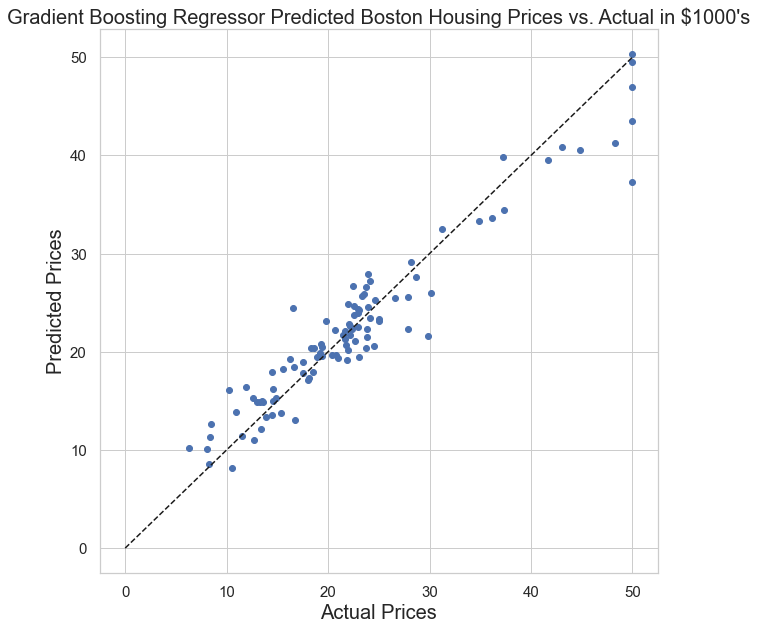

In [113]:
Y_pred = plot_residuals(test_model, X_test, Y_test)

In [89]:
# Gets the top n residuals for plotting using Shapley values

def get_top_residuals(model, X_test, Y_test, n=10):
    Y_pred = model.predict(X_test)
    
    fit_preprocessor = model.named_steps['preprocessor']

    residuals_df = pd.DataFrame({'Y_Actual':Y_test, 'Y_Predicted': Y_pred})
    residuals_df['Residual'] = residuals_df['Y_Actual'] - residuals_df['Y_Predicted']
    residuals_df['Residual_Abs'] = abs(residuals_df['Y_Actual'] - residuals_df['Y_Predicted'])
    
    X_resid_sorted = pd.concat([residuals_df, X_test], axis = 1, sort = False)
    X_resid_sorted.sort_values(by=['Residual_Abs'], ascending = False, inplace = True)
    print("Preview of Table of Residuals and X Inputs: ")
    display(X_resid_sorted.head(10))

    X_test_tf_residuals = pd.DataFrame(fit_preprocessor.transform(X_resid_sorted[X_test.columns.to_list()].head(n)),
                                                                  columns = X_test_tf.columns.to_list())
    
    print("Preview of X Inputs: ")
    display(X_test_tf_residuals.head(10))
    
    return X_resid_sorted, X_test_tf_residuals

In [90]:
X_resid_sorted, X_test_tf_residuals = get_top_residuals(test_model, X_test, Y_test)

Preview of Table of Residuals and X Inputs: 


,Y_Actual,Y_Predicted,Residual,Residual_Abs,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat
225,50.0,37.278081,12.721919,12.721919,0.52693,0.0,6.20,0,0.504,8.725,83.0,2.8944,8,307,17.4,4.63
473,29.8,21.654451,8.145549,8.145549,4.64689,0.0,18.10,0,0.614,6.980,67.6,2.5329,24,666,20.2,11.66
342,16.5,24.493594,-7.993594,7.993594,0.02498,0.0,1.89,0,0.518,6.540,59.7,6.2669,1,422,15.9,8.65
233,48.3,41.255409,7.044591,7.044591,0.33147,0.0,6.20,0,0.507,8.247,70.4,3.6519,8,307,17.4,3.95
257,50.0,43.474044,6.525956,6.525956,0.61154,20.0,3.97,0,0.647,8.704,86.9,1.8010,5,264,13.0,5.12
426,10.2,16.063497,-5.863497,5.863497,12.24720,0.0,18.10,0,0.584,5.837,59.7,1.9976,24,666,20.2,15.69
407,27.9,22.360918,5.539082,5.539082,11.95110,0.0,18.10,0,0.659,5.608,100.0,1.2852,24,666,20.2,12.13
406,11.9,16.398122,-4.498122,4.498122,20.71620,0.0,18.10,0,0.659,4.138,100.0,1.1781,24,666,20.2,23.34
224,44.8,40.549490,4.250510,4.250510,0.31533,0.0,6.20,0,0.504,8.266,78.3,2.8944,8,307,17.4,4.14
298,22.5,26.745297,-4.245297,4.245297,0.06466,70.0,2.24,0,0.400,6.345,20.1,7.8278,5,358,14.8,4.97


Preview of X Inputs: 


,chas_1,crim,zn,indus,nox,rooms,age,dis,rad,tax,ptratio,lstat
0,0.0,0.52693,0.0,6.20,0.504,8.725,83.0,2.8944,8.0,307.0,17.4,4.63
1,0.0,4.64689,0.0,18.10,0.614,6.980,67.6,2.5329,24.0,666.0,20.2,11.66
2,0.0,0.02498,0.0,1.89,0.518,6.540,59.7,6.2669,1.0,422.0,15.9,8.65
3,0.0,0.33147,0.0,6.20,0.507,8.247,70.4,3.6519,8.0,307.0,17.4,3.95
4,0.0,0.61154,20.0,3.97,0.647,8.704,86.9,1.8010,5.0,264.0,13.0,5.12
5,0.0,12.24720,0.0,18.10,0.584,5.837,59.7,1.9976,24.0,666.0,20.2,15.69
6,0.0,11.95110,0.0,18.10,0.659,5.608,100.0,1.2852,24.0,666.0,20.2,12.13
7,0.0,20.71620,0.0,18.10,0.659,4.138,100.0,1.1781,24.0,666.0,20.2,23.34
8,0.0,0.31533,0.0,6.20,0.504,8.266,78.3,2.8944,8.0,307.0,17.4,4.14
9,0.0,0.06466,70.0,2.24,0.400,6.345,20.1,7.8278,5.0,358.0,14.8,4.97


### Feature Importance

Using Permutation Importance

In [91]:
# Feature Importance - Permutation Importance
def permutation_importance(test_model, X_test, Y_test):
    perm = PermutationImportance(test_model, random_state=1, scoring = 'neg_root_mean_squared_error').fit(X_test, Y_test)
    display(eli5.show_weights(perm, feature_names = X_test.columns.tolist()))
    return

In [92]:
permutation_importance(test_model, X_test, Y_test)

Weight,Feature
4.5054 ± 0.8219,lstat
3.4379 ± 0.4935,rooms
0.8462 ± 0.1299,nox
0.7924 ± 0.2631,ptratio
0.7620 ± 0.1332,dis
0.6005 ± 0.1675,crim
0.5069 ± 0.2187,tax
0.3263 ± 0.1078,indus
0.2639 ± 0.1732,age
0.2505 ± 0.1310,rad


### Partial Dependence

In [93]:
def partial_dependence_plots(X_test, feature_list, ml_model):
    for feature_to_plot in feature_list:
        pdp_dist = pdp.pdp_isolate(model=ml_model, dataset=X_test, model_features=feature_list, feature=feature_to_plot)
        pdp.pdp_plot(pdp_dist, feature_to_plot)
        plt.show()
    return

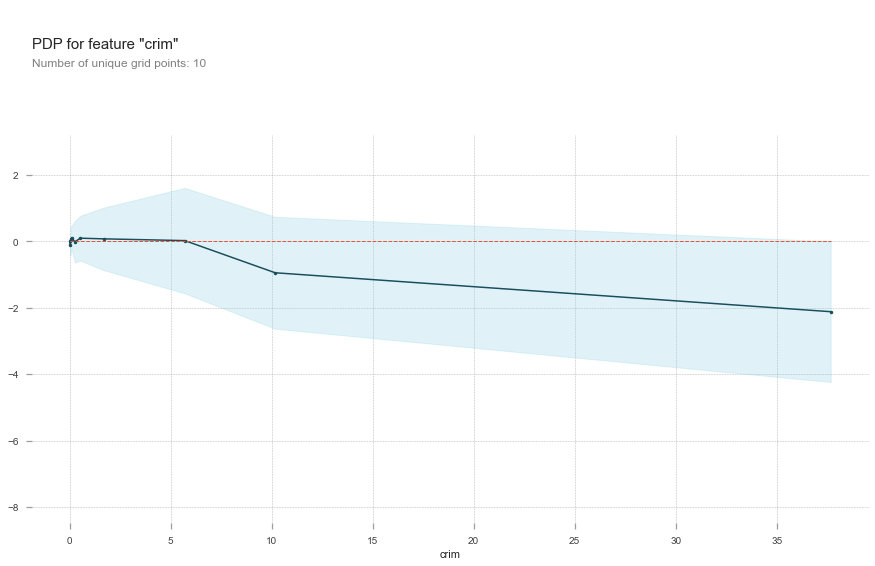

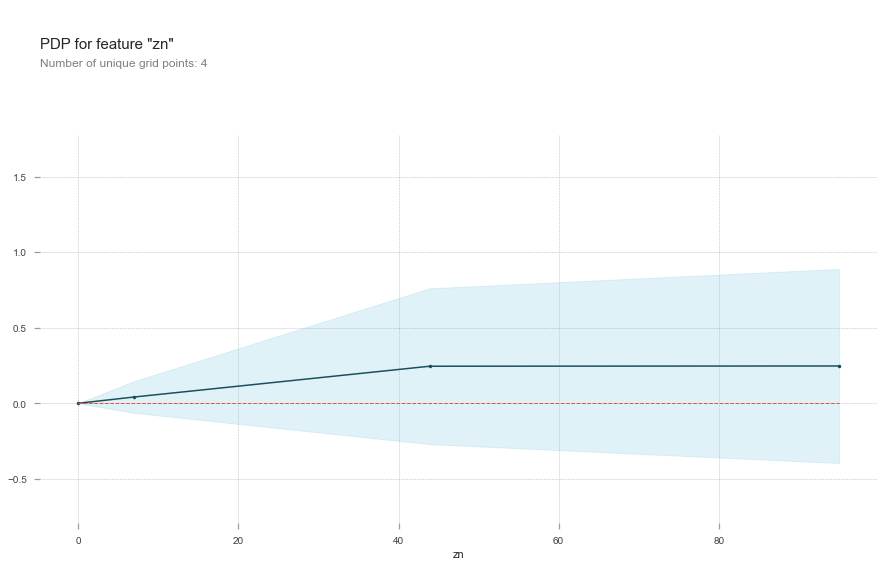

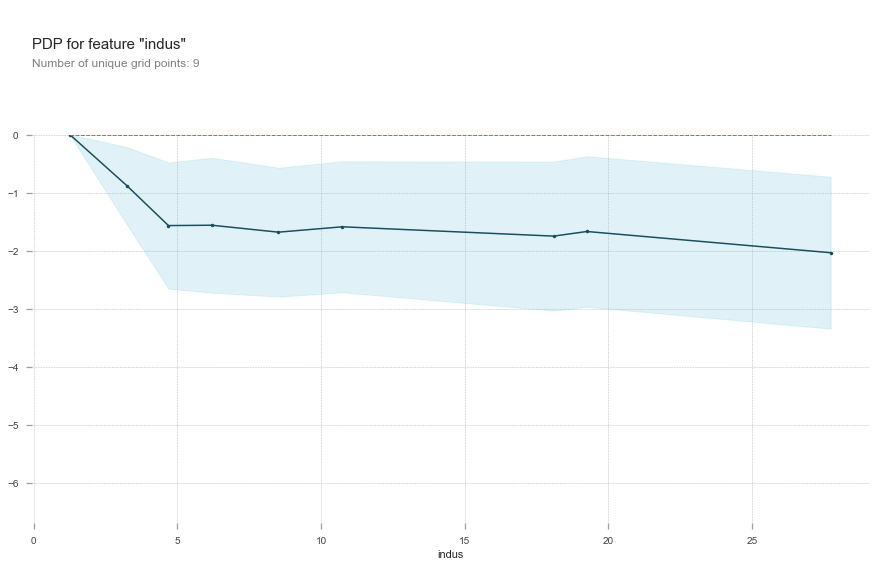

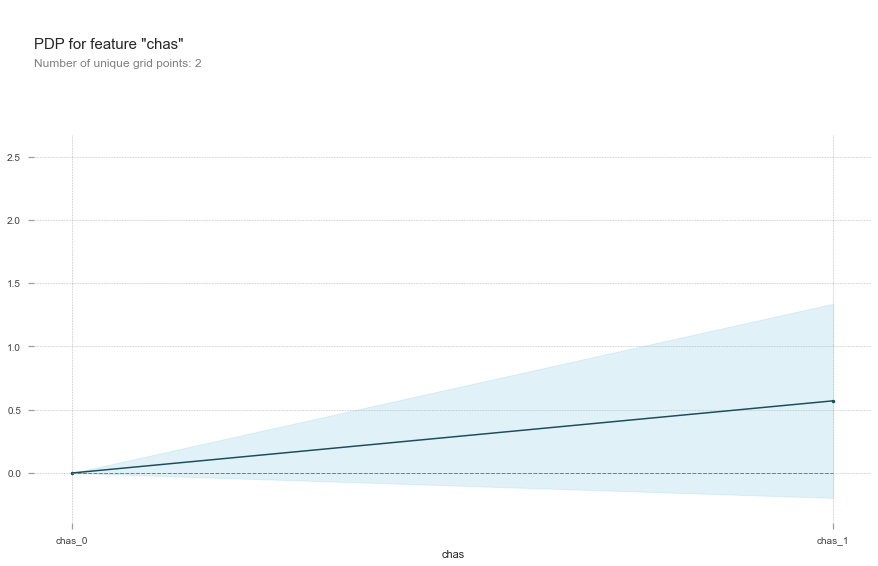

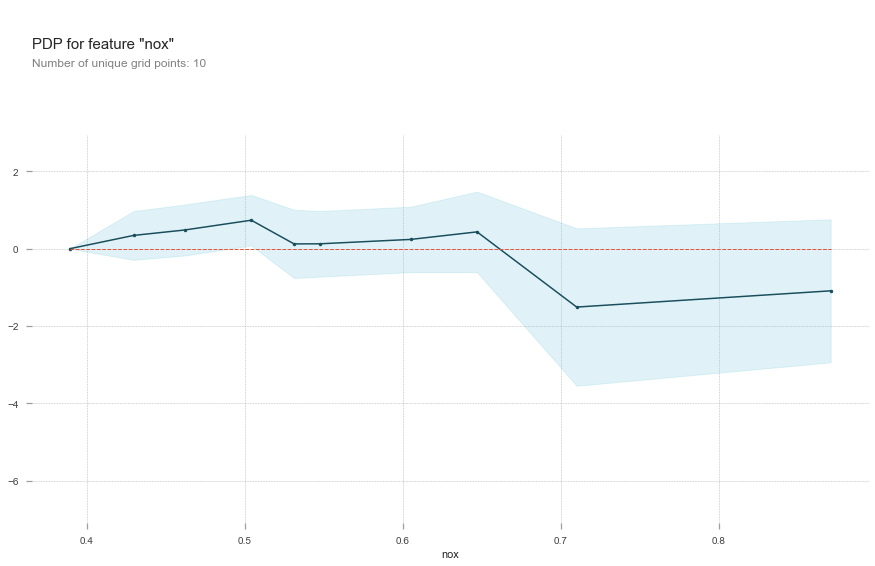

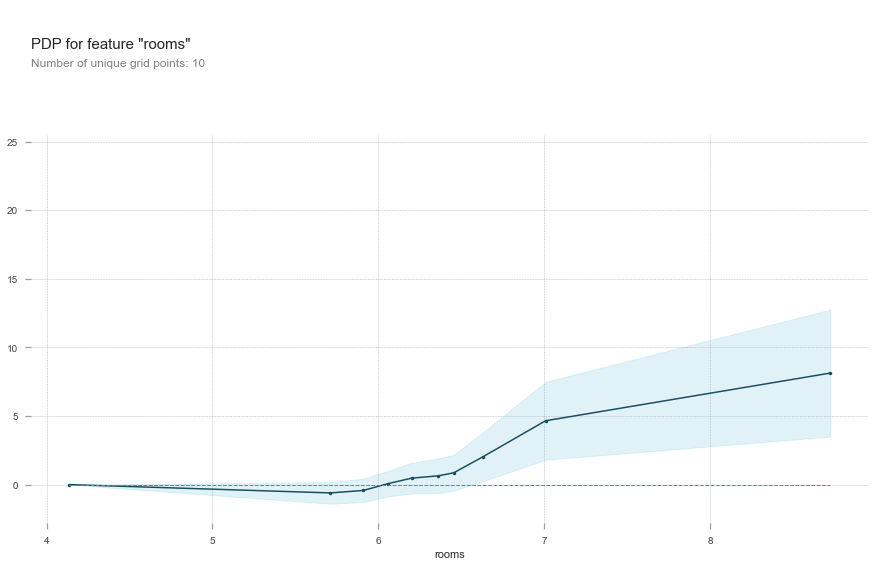

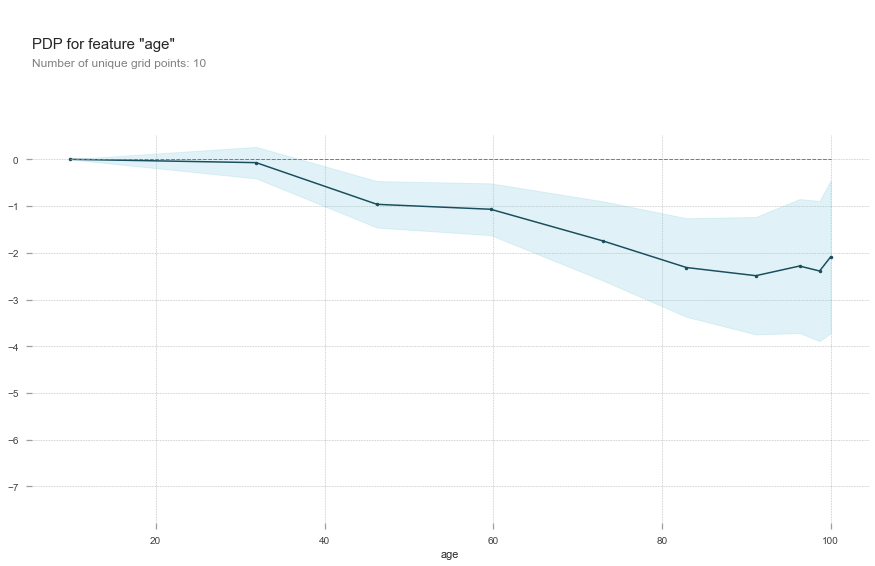

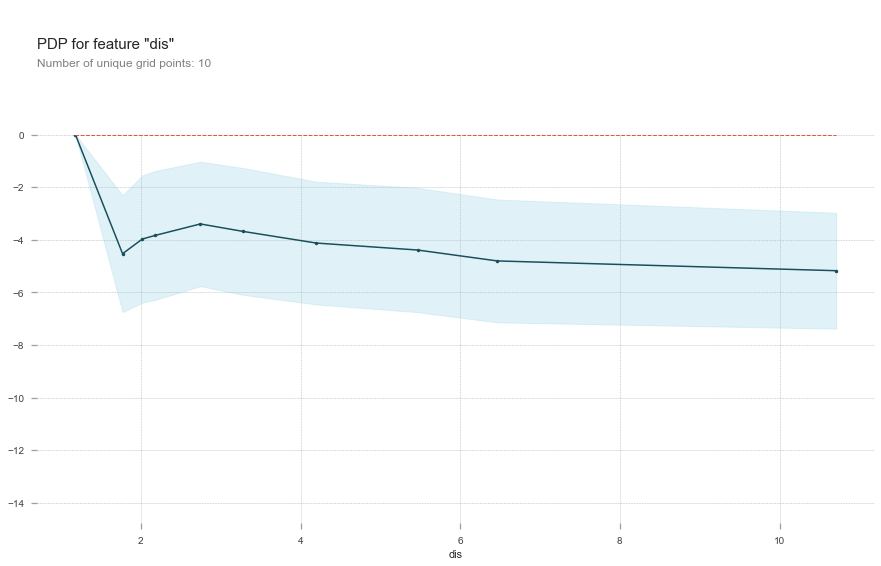

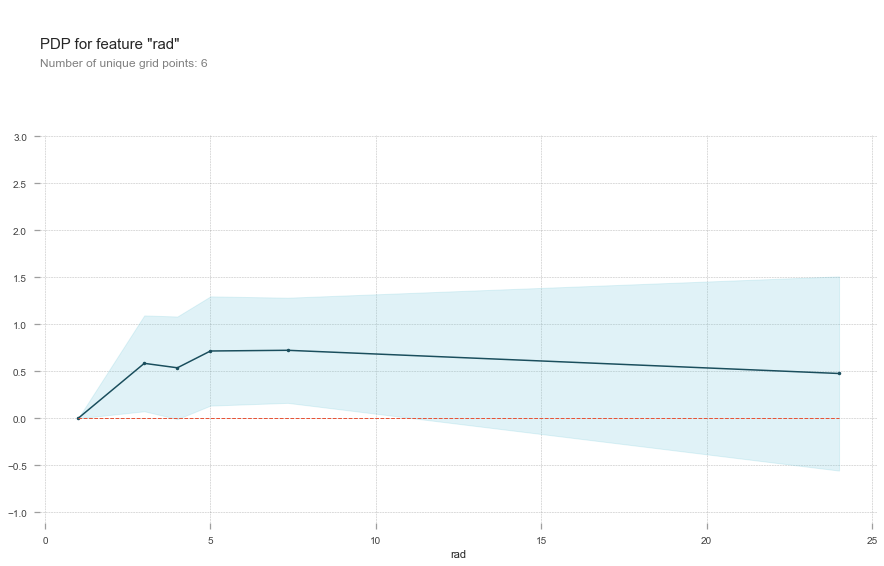

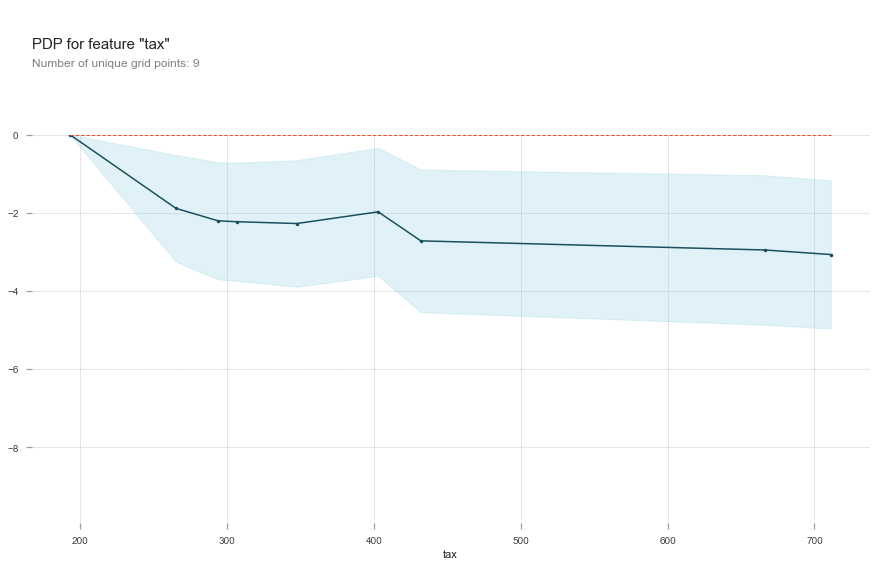

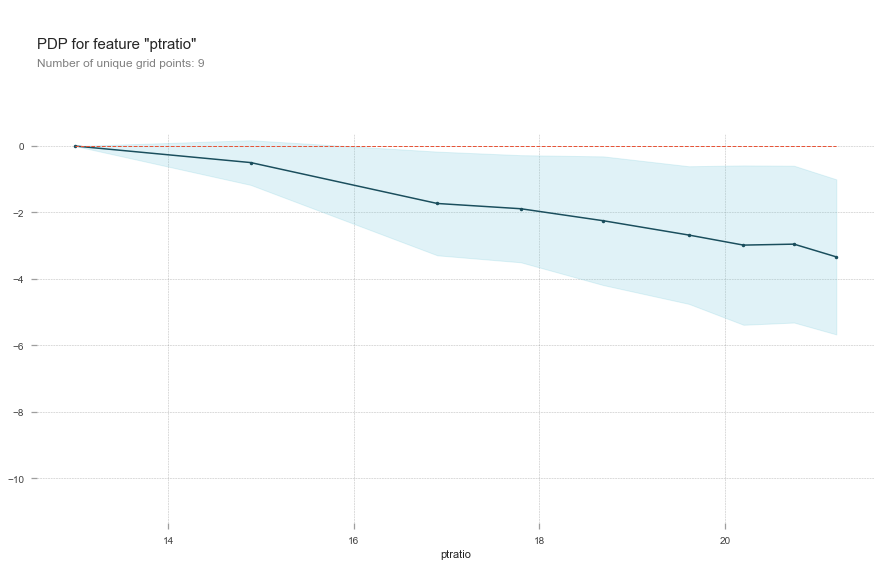

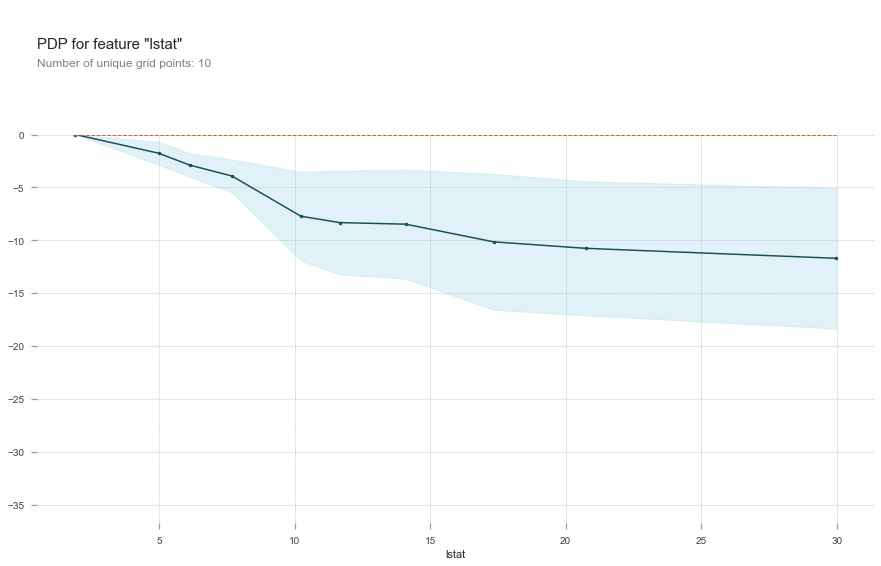

In [94]:
partial_dependence_plots(X_test, X_test.columns.to_list(), test_model)

### Shapley Value Analysis

In [99]:
def shap_summary_plot_tree(model, X_train, X_test, feature_list):
    shap.initjs()
    explainer = shap.TreeExplainer(model, X_train)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=feature_list)
    return

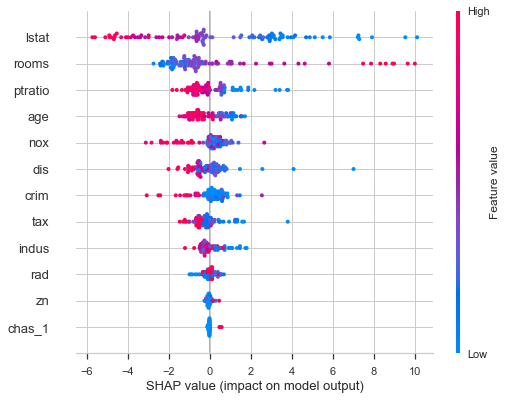

In [100]:
shap_summary_plot_tree(test_regressor, X_train_tf, X_test_tf, feature_list=X_test_tf.columns.to_list())

In [103]:
# Gets the Shapley Values using the original values as labels

def shap_explainer_tree_residuals(model, X_train, X_resid_sorted, X_test, X_orig, feature_list, number_of_exp=10):
    shap.initjs()
    explainer = shap.TreeExplainer(model, X_train)
    shap_values = explainer.shap_values(X_test)
    for i in range(0, number_of_exp):
        print("Actual Value: ", str(X_resid_sorted.iloc[i, 0]))
        print("Predicted Value: ", str(X_resid_sorted.iloc[i, 1]))
        print("Difference (Residual): ", str(X_resid_sorted.iloc[i, 2]))
        display(shap.force_plot(explainer.expected_value, shap_values[i,:], X_orig.values[i,:],
                    feature_names=feature_list))
    return

In [104]:
shap_explainer_tree_residuals(test_regressor, X_train_tf, X_resid_sorted, X_test_tf_residuals, X_orig=X_test_tf_residuals,
                      feature_list=X_test_tf_residuals.columns.to_list(), number_of_exp=5)

Actual Value:  50.0
Predicted Value:  37.278080807468065
Difference (Residual):  12.721919192531935


Actual Value:  29.8
Predicted Value:  21.654451233776562
Difference (Residual):  8.145548766223438


Actual Value:  16.5
Predicted Value:  24.493593623065145
Difference (Residual):  -7.993593623065145


Actual Value:  48.3
Predicted Value:  41.25540873655269
Difference (Residual):  7.044591263447309


Actual Value:  50.0
Predicted Value:  43.47404372370732
Difference (Residual):  6.525956276292682


In [105]:
def shap_dependence_plot(test_model, X_train, X_test, y_col, x_col):
    explainer = shap.TreeExplainer(test_model, X_train)
    shap_values = explainer.shap_values(X_test)
    shap.dependence_plot(x_col, shap_values, X_test, interaction_index=y_col)
    return

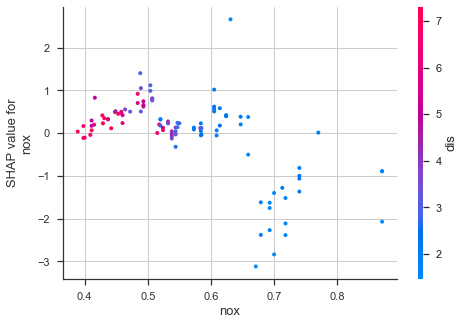

In [106]:
shap_dependence_plot(test_regressor, X_train_tf, X_test_tf, 'dis', 'nox')

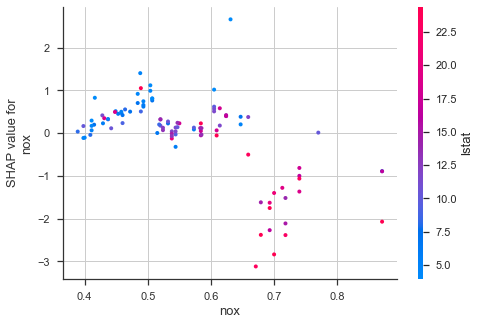

In [107]:
shap_dependence_plot(test_regressor, X_train_tf, X_test_tf, 'lstat', 'nox')

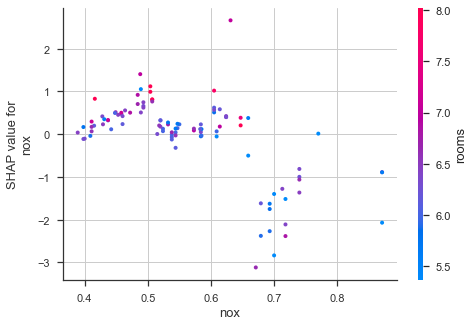

In [108]:
shap_dependence_plot(test_regressor, X_train_tf, X_test_tf, 'rooms', 'nox')

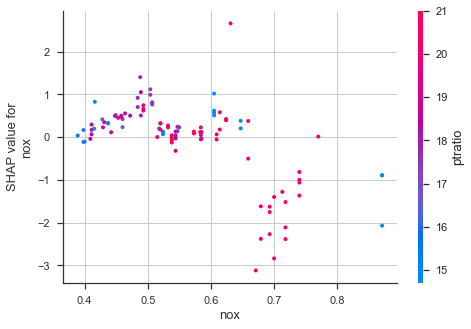

In [109]:
shap_dependence_plot(test_regressor, X_train_tf, X_test_tf, 'ptratio', 'nox')

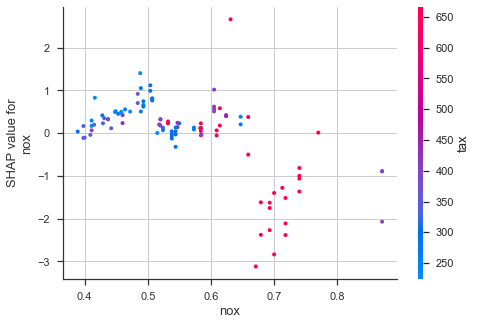

In [110]:
shap_dependence_plot(test_regressor, X_train_tf, X_test_tf, 'tax', 'nox')

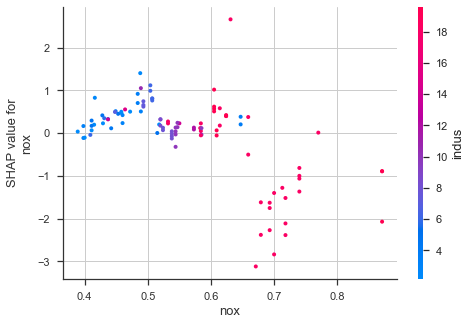

In [111]:
shap_dependence_plot(test_regressor, X_train_tf, X_test_tf, 'indus', 'nox')